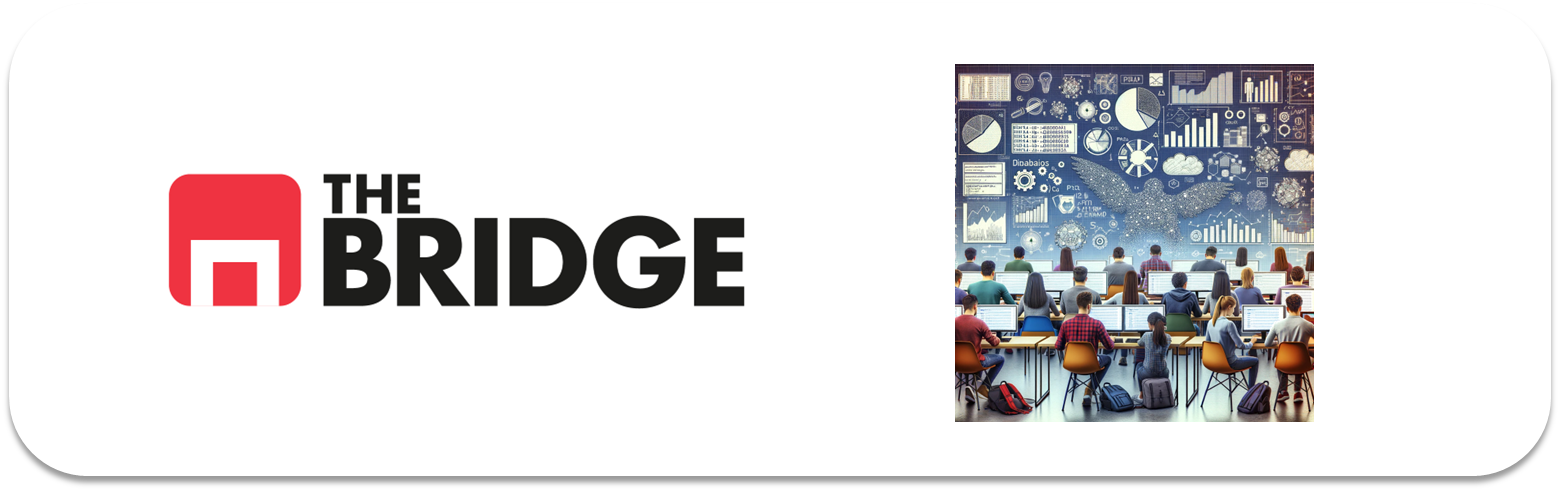

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



## 1. Carga el dataset del Titanic.

In [71]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

path = "./data/titanic.csv"
df = pd.read_csv(path)

print(df.shape)
display(df.head())


(891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


## 2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.

In [73]:
target_col = "survived"

# Features elegidas (simples, sin fuga de información)
use_cols = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked", "alone"]

data = df[[target_col] + use_cols].copy()

# alone es boolean -> lo paso a 0/1
data["alone"] = data["alone"].astype(int)

print("Nulos por columna:")
print(data.isna().sum().sort_values(ascending=False))

display(data.head())

Nulos por columna:
age         177
embarked      2
survived      0
pclass        0
sex           0
sibsp         0
parch         0
fare          0
alone         0
dtype: int64


,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone
0,0,3,male,22.0,1,0,7.2500,S,0
1,1,1,female,38.0,1,0,71.2833,C,0
2,1,3,female,26.0,0,0,7.9250,S,1
3,1,1,female,35.0,1,0,53.1000,S,0
4,0,3,male,35.0,0,0,8.0500,S,1


## 3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.

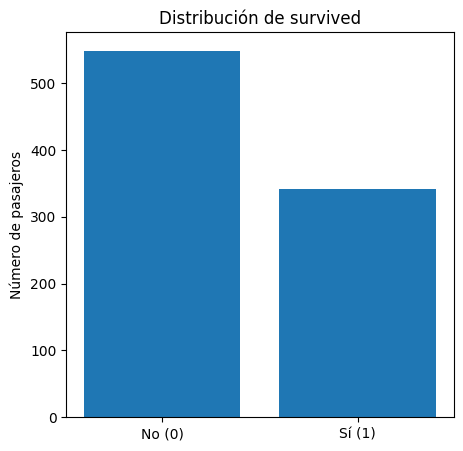

survived
0    549
1    342
Name: count, dtype: int64
survived
0    0.616162
1    0.383838
Name: count, dtype: float64


In [74]:
counts = data[target_col].value_counts().sort_index()
rates = counts / counts.sum()

plt.figure(figsize=(5,5))
plt.bar(["No (0)", "Sí (1)"], counts.values)
plt.title("Distribución de survived")
plt.ylabel("Número de pasajeros")
plt.show()

print(counts)
print(rates)

### A primera vista hay más personas que no sobrevivieron y no es muy desproporcionado, así que accuracy puede parecer buen modelo, pero sabemos que depende mucho de las clases, ya que la clase 1 sobrevivieron muchos mas que en la clase 3. Por eso tiene sentido mirar precision/recall/F1 y ROC-AUC.

## 4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.


In [75]:
estratificar_embarked = data["embarked"].fillna("Missing")

train_df, test_df = train_test_split(data,test_size=0.2,random_state=42,stratify=estratificar_embarked)

print("Train:", train_df.shape)
print("Test:", test_df.shape)

print("\nDistribución Train de embarked:")
print(train_df["embarked"].fillna("Missing").value_counts(normalize=True))

print("\nDistribución Test de embarked:")
print(test_df["embarked"].fillna("Missing").value_counts(normalize=True))


Train: (712, 9)
Test: (179, 9)

Distribución Train de embarked:
embarked
S          0.723315
C          0.188202
Q          0.085674
Missing    0.002809
Name: proportion, dtype: float64

Distribución Test de embarked:
embarked
S    0.720670
C    0.189944
Q    0.089385
Name: proportion, dtype: float64


## 5. Construye las parejas X,y de train y test.


In [76]:
X_train = train_df[use_cols].copy()
y_train = train_df[target_col].copy()

X_test = test_df[use_cols].copy()
y_test = test_df[target_col].copy()

print("X_Train", X_train.shape)
print("Y_Train", y_train.shape)
print("X_Test", X_test.shape)
print("Y_Test", y_test.shape)

X_Train (712, 8)
Y_Train (712,)
X_Test (179, 8)
Y_Test (179,)


## 6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.

In [77]:
num_cols = ["pclass", "age", "sibsp", "parch", "fare", "alone"]
cat_cols = ["sex", "embarked"]

num_means = X_train[num_cols].mean(numeric_only=True)
cat_modes = X_train[cat_cols].mode(dropna=True).iloc[0]

X_train_imp = X_train.copy()
X_test_imp = X_test.copy()

X_train_imp[num_cols] = X_train_imp[num_cols].fillna(num_means)
X_test_imp[num_cols] = X_test_imp[num_cols].fillna(num_means)

X_train_imp[cat_cols] = X_train_imp[cat_cols].fillna(cat_modes)
X_test_imp[cat_cols] = X_test_imp[cat_cols].fillna(cat_modes)

print("Nulos tras imputación:")
print("Train:\n", X_train_imp.isna().sum())
print("Test:\n", X_test_imp.isna().sum())

print("\nMedias usadas:\n", num_means)
print("\nModas usadas:\n", cat_modes)


Nulos tras imputación:
Train:
 pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
alone       0
dtype: int64
Test:
 pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
alone       0
dtype: int64

Medias usadas:
 pclass     2.337079
age       29.775330
sibsp      0.498596
parch      0.375000
fare      31.839822
alone      0.603933
dtype: float64

Modas usadas:
 sex         male
embarked       S
Name: 0, dtype: object


## 7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.


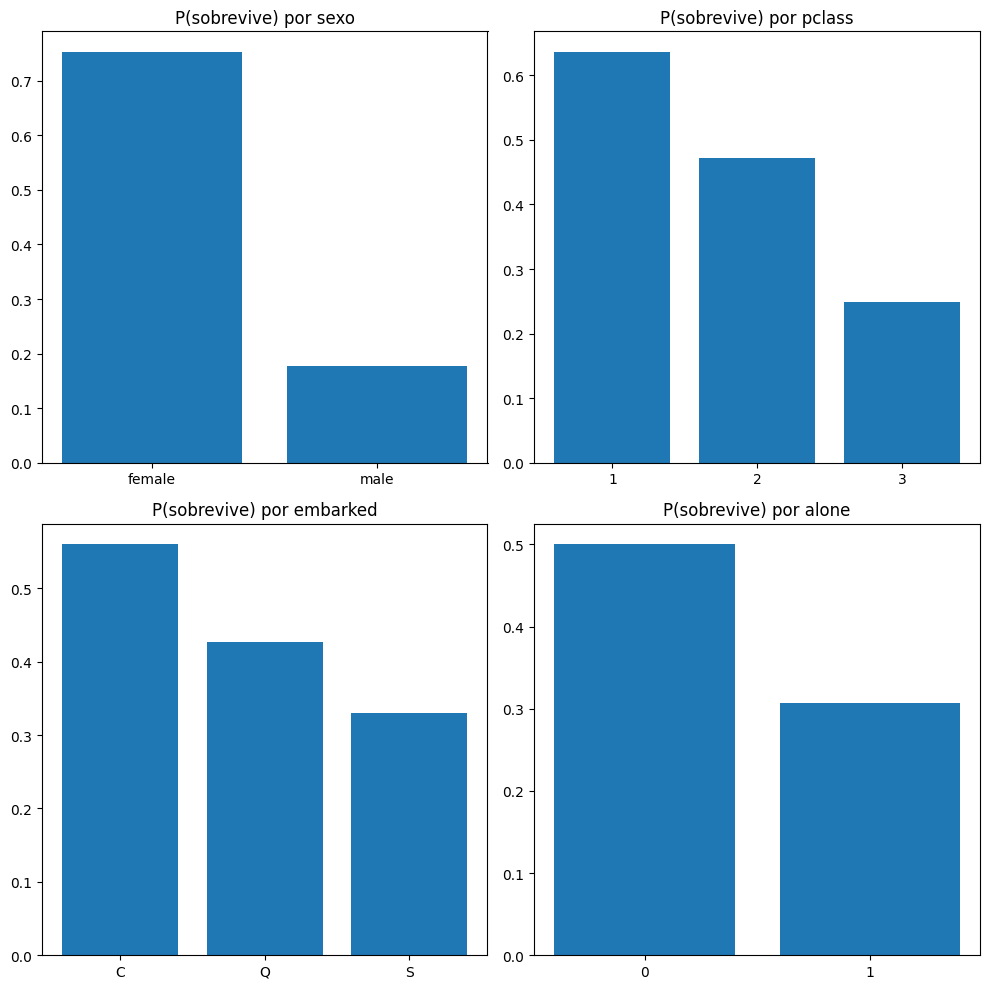

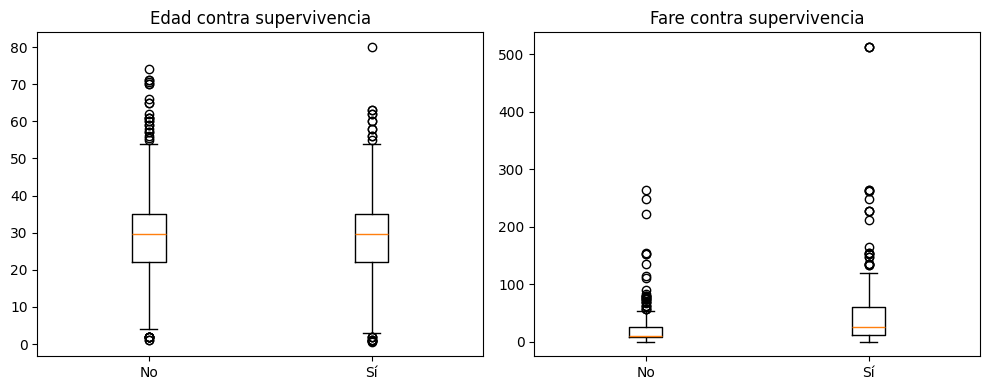

Ratios:
sex
female    0.752941
male      0.177243
Name: survived, dtype: float64 
 pclass
1    0.636364
2    0.471831
3    0.249383
Name: survived, dtype: float64 
 embarked
C    0.559701
Q    0.426230
S    0.330097
Name: survived, dtype: float64 
 alone
0    0.500000
1    0.306977
Name: survived, dtype: float64


In [78]:
def survival_rate_by(df_, col):
    return df_.groupby(col)["survived"].mean().sort_values(ascending=False)

rates_sex = survival_rate_by(train_df, "sex")
rates_pclass = survival_rate_by(train_df, "pclass")
rates_embarked = survival_rate_by(train_df, "embarked")
rates_alone = survival_rate_by(train_df, "alone")

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

axes[0].bar(rates_sex.index.astype(str), rates_sex.values)
axes[0].set_title("P(sobrevive) por sexo")

axes[1].bar(rates_pclass.index.astype(str), rates_pclass.values)
axes[1].set_title("P(sobrevive) por pclass")

axes[2].bar(rates_embarked.index.astype(str), rates_embarked.values)
axes[2].set_title("P(sobrevive) por embarked")

axes[3].bar(rates_alone.index.astype(str), rates_alone.values)
axes[3].set_title("P(sobrevive) por alone")

plt.tight_layout()
plt.show()

# Edad/Fare vs survived (boxplot simple)
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].boxplot([X_train_imp.loc[y_train==0, "age"], X_train_imp.loc[y_train==1, "age"]],
                tick_labels=["No", "Sí"])
axes[0].set_title("Edad contra supervivencia")

axes[1].boxplot([X_train_imp.loc[y_train==0, "fare"], X_train_imp.loc[y_train==1, "fare"]],
                tick_labels=["No", "Sí"])
axes[1].set_title("Fare contra supervivencia")

plt.tight_layout()
plt.show()

print("Ratios:")
print(rates_sex, "\n", rates_pclass, "\n", rates_embarked, "\n", rates_alone)


Por lo tanto Respecto al sexo: female= 0.752941 vs male= 0.177243 mucha diferencia. En Clase: 1ª= 0.636364 mayor que 2ª= 0.471831 y mayor que 3ª= 0.249383 y en Embarques: C > Q > S son diferencias moderadas y viajar acompañado mejora bastante la supervivencia acompañado es 0=0.50 y solo es 1=0.307)

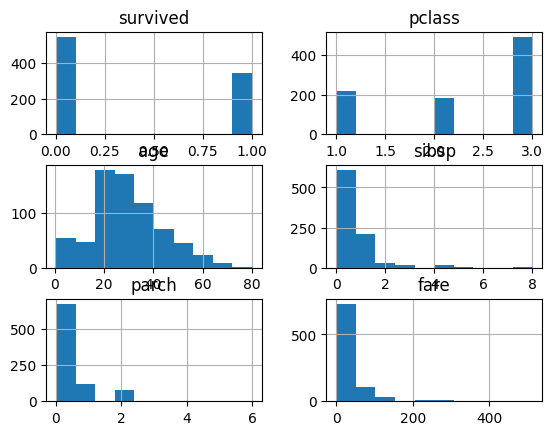

In [79]:
df.hist();

## 8. Trata las variables para que funcionen lo mejor posible en el modelo.

In [88]:
def add_log_features(X: pd.DataFrame) -> pd.DataFrame:
    X2 = X.copy()
    X2["fare_log1p"] = np.log1p(X2["fare"])
    X2["sibsp_log1p"] = np.log1p(X2["sibsp"])
    X2["parch_log1p"] = np.log1p(X2["parch"])

    # sustituyo los originales para no duplicar información
    X2 = X2.drop(columns=["fare", "sibsp", "parch"])
    return X2

tr_features_finales = add_log_features(X_train_imp)
te_features_finales = add_log_features(X_test_imp)

# convierto las variables categoricas a numericas
tr_convertidas = pd.get_dummies(tr_features_finales, columns=cat_cols, drop_first=True)
te_convertidas = pd.get_dummies(te_features_finales, columns=cat_cols, drop_first=True)

# Asi test tiene las mismas features que train
te_final = te_convertidas.reindex(columns=tr_convertidas.columns, fill_value=0)

# Escalado
escalado = StandardScaler()
tr_escalado = pd.DataFrame(
    escalado.fit_transform(tr_convertidas),
    columns=tr_convertidas.columns,
    index=tr_convertidas.index
)
te_escalado = pd.DataFrame(
    escalado.transform(te_convertidas),
    columns=tr_convertidas.columns,
    index=te_final.index
)

print("\nX_train final:", tr_escalado.shape)
print("X_test final:", te_escalado.shape)
display(tr_escalado.head())


X_train final: (712, 9)
X_test final: (179, 9)


,pclass,age,alone,fare_log1p,sibsp_log1p,parch_log1p,sex_male,embarked_Q,embarked_S
503,0.799839,0.551691,0.809823,-0.600964,-0.619361,-0.531582,-1.338715,-0.306108,0.614147
621,-1.613235,0.933502,-1.234837,1.075434,0.923151,-0.531582,0.746985,-0.306108,0.614147
751,0.799839,-1.815536,-1.234837,-0.351563,-0.619361,1.173401,0.746985,-0.306108,0.614147
276,0.799839,1.162589,0.809823,-0.798097,-0.619361,-0.531582,-1.338715,-0.306108,0.614147
219,-0.406698,0.017156,0.809823,-0.515467,-0.619361,-0.531582,0.746985,-0.306108,0.614147


## 9. Construye un modelo de regresión logística.

In [81]:
lr = LogisticRegression(max_iter=2000)
lr.fit(tr_escalado, y_train)

print("Modelo entrenado.")

Modelo entrenado.


## 10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.

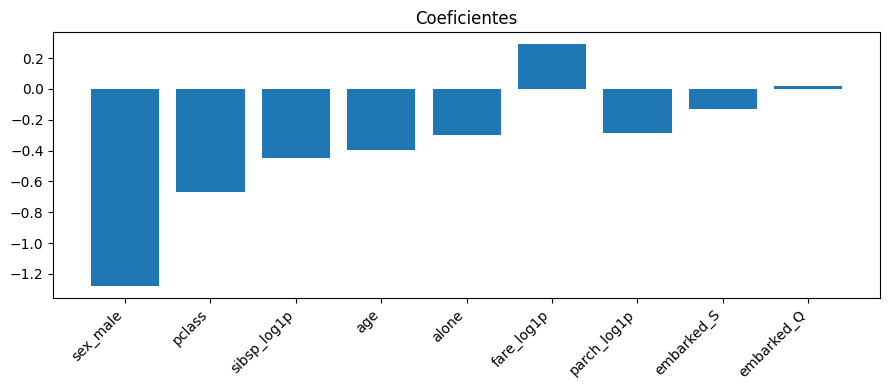

Coeficientes:
 sex_male      -1.278030
pclass        -0.671171
sibsp_log1p   -0.446634
age           -0.398128
alone         -0.298240
fare_log1p     0.289279
parch_log1p   -0.284204
embarked_S    -0.128273
embarked_Q     0.022456
dtype: float64


In [82]:
coef = pd.Series(lr.coef_[0], index=tr_escalado.columns)
coef_sorted = coef.sort_values(key=lambda s: s.abs(), ascending=False)

plt.figure(figsize=(9,4))
plt.bar(coef_sorted.index[:10], coef_sorted.values[:10])
plt.title("Coeficientes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("Coeficientes:\n", coef_sorted.head(10))

Lo que podemos ver es sex_male es muy negativo, ya que ser hombre tiene baja probabilidad de supervivencia.

que pclass es negativo, cuanto pero sea la clase menos probabilidades de supervivencia tienes

que age es negativo al contrario de lo que puede parecer es a más edad menos probabilidades de supervivencia, pero claro los niños y las mujeres primero.

y que fare_log1p es positivo por lo que a más “fare” más probabilidad de supervivencia tienes

## 11. Procesa el dataset de Test para que puedas usarlo en la evaluación 

Lo he ido realizando a la par que con Train, ya que temía dejarme algo por el camino


## 12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.

,dataset,accuracy,precision,recall,f1,auc
0,train,0.801966,0.764000,0.699634,0.730402,0.859684
1,test,0.782123,0.741935,0.666667,0.702290,0.855731


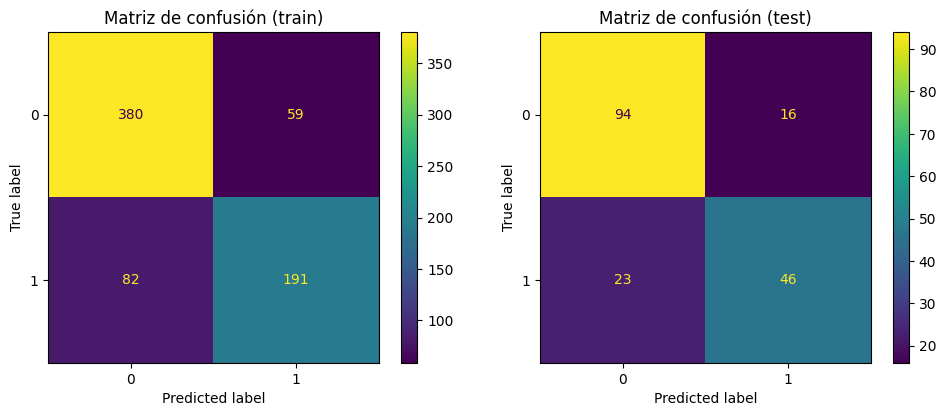

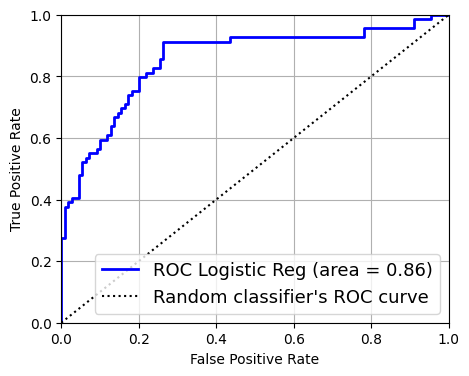

Classification report:
              precision    recall  f1-score   support

           0      0.803     0.855     0.828       110
           1      0.742     0.667     0.702        69

    accuracy                          0.782       179
   macro avg      0.773     0.761     0.765       179
weighted avg      0.780     0.782     0.780       179



,y_real,y_pred,proba_survive,acierto
704,0,0,0.098425,1
557,0,1,0.652316,0
212,0,0,0.115551,1
235,0,1,0.599801,0
871,1,1,0.815439,1
224,1,0,0.434613,0
586,0,0,0.143398,1
803,1,0,0.284232,0
364,0,0,0.144855,1
787,0,0,0.088772,1


Accuracy: 0.7821229050279329
Errores: 39


In [93]:
def eval_binary(model, X, y, label):
    proba = model.predict_proba(X)[:, 1]
    pred = (proba >= 0.5).astype(int)
    fpr, tpr, thr = roc_curve(y, proba)
    #incluyo todas las metricas
    metrics = {
        "dataset": label,
        "accuracy": accuracy_score(y, pred),
        "precision": precision_score(y, pred, zero_division=0),
        "recall": recall_score(y, pred, zero_division=0),
        "f1": f1_score(y, pred, zero_division=0),
        "auc": auc(fpr, tpr),
    }
    return pred, proba, metrics

pred_tr, proba_tr, m_tr = eval_binary(lr, tr_escalado, y_train, "train")
pred_te, proba_te, m_te = eval_binary(lr, te_escalado, y_test, "test")

metrics_df = pd.DataFrame([m_tr, m_te])
display(metrics_df)

# Matrices de confusión
cm_tr = confusion_matrix(y_train, pred_tr)
cm_te = confusion_matrix(y_test, pred_te)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm_tr).plot(ax=axes[0], values_format="d")
axes[0].set_title("Matriz de confusión (train)")
ConfusionMatrixDisplay(cm_te).plot(ax=axes[1], values_format="d")
axes[1].set_title("Matriz de confusión (test)")
plt.tight_layout()
plt.show()

# Curva ROC
fpr, tpr, thr = roc_curve(y_test, proba_te)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.legend(loc="lower right", fontsize=13)
plt.axis([0, 1, 0, 1])
plt.show()

print("Classification report:")
print(classification_report(y_test, pred_te, digits=3))

# Comparación predicciones vs reales
compare = pd.DataFrame({
    "y_real": y_test.values,
    "y_pred": pred_te,
    "proba_survive": proba_te
}, index=y_test.index)

compare["acierto"] = (compare["y_real"] == compare["y_pred"]).astype(int)

display(compare.head(20))
print("Accuracy:", compare["acierto"].mean())
print("Errores:", (compare["acierto"] == 0).sum())

train y test están cerca, AUC prácticamente igual, accuracy baja un poco, así que no parece que el modelo esté sobreajustado.

## 13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.

In [ ]:
ages = np.arange(30, 41)  # 30..40 inclusive

escenario = pd.DataFrame({
    "pclass": 2,
    "sex": "male",
    "age": ages.astype(float),
    "sibsp": 0,
    "parch": 0,
    "fare": 0.0,
    "embarked": "S",
    "alone": 1
})

# mismo pipeline de tratamiento
escenario_features = add_log_features(escenario)

escenario_ohe = pd.get_dummies(escenario_features, columns=cat_cols, drop_first=True)
escenario_ohe = escenario_ohe.reindex(columns=tr_convertidas.columns, fill_value=0)

escenario_scaled = escalado.transform(escenario_ohe)
escenario_proba = lr.predict_proba(escenario_scaled)[:, 1]

print("Probabilidad media de un hombre entre 30 y 40, que embarca solo desde southampton")
res_escenario = pd.DataFrame({"edad": ages, "proba_survive": escenario_proba})
display(res_escenario)

print("Probabilidad media", escenario_proba.mean())

Probabilidad media de un hombre entre 30 y 40, que embarca colo desde southampton


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,edad,proba_survive
0,30,0.701251
1,31,0.694843
2,32,0.688359
3,33,0.681800
4,34,0.675168
5,35,0.668465
6,36,0.661694
7,37,0.654855
8,38,0.647952
9,39,0.640986


Probabilidad media 0.6681211585436138


## 14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.

In [103]:
other_target = "pclass"

# Incluyo survived; porque el target es pclass
cols = ["survived", "sex", "age", "sibsp", "parch", "fare", "embarked", "alone"]

X_train_modificado = train_df[cols].copy()
y_train_modificado = train_df[other_target].copy()

X_test_modificado = test_df[cols].copy()
y_test_modificado = test_df[other_target].copy()

# imputación
num_cols_modificado = ["survived", "age", "sibsp", "parch", "fare", "alone"]
cat_cols_modificado = ["sex", "embarked"]

num_means_modificado = X_train_modificado[num_cols_modificado].mean(numeric_only=True)
cat_modes_modificado = X_train_modificado[cat_cols_modificado].mode(dropna=True).iloc[0]

X_train_modificado_imp = X_train_modificado.copy()
X_test_modificado_imp = X_test_modificado.copy()

X_train_modificado_imp[num_cols_modificado] = X_train_modificado_imp[num_cols_modificado].fillna(num_means_modificado)
X_test_modificado_imp[num_cols_modificado] = X_test_modificado_imp[num_cols_modificado].fillna(num_means_modificado)

X_train_modificado_imp[cat_cols_modificado] = X_train_modificado_imp[cat_cols_modificado].fillna(cat_modes_modificado)
X_test_modificado_imp[cat_cols_modificado] = X_test_modificado_imp[cat_cols_modificado].fillna(cat_modes_modificado)

# add_log_features lo copio aqui para no tutlizar el método de arriba
def add_log_features(X: pd.DataFrame) -> pd.DataFrame:
    X2 = X.copy()
    X2["fare_log1p"] = np.log1p(X2["fare"])
    X2["sibsp_log1p"] = np.log1p(X2["sibsp"])
    X2["parch_log1p"] = np.log1p(X2["parch"])

    # sustituyo los originales para no duplicar información
    X2 = X2.drop(columns=["fare", "sibsp", "parch"])
    return X2

Xtr_modificado_feat = add_log_features(X_train_modificado_imp)
Xte_modificado_feat = add_log_features(X_test_modificado_imp)

Xtr_modificado_dummy = pd.get_dummies(Xtr_modificado_feat, columns=cat_cols_modificado, drop_first=True)
Xte_modificado_dummy = pd.get_dummies(Xte_modificado_feat, columns=cat_cols_modificado, drop_first=True)
Xte_modificado_dummy = Xte_modificado_dummy.reindex(columns=Xtr_modificado_dummy.columns, fill_value=0)

escalado_modificado = StandardScaler()
Xtr_modificado_escalado = escalado_modificado.fit_transform(Xtr_modificado_dummy)
Xte_modificado_escalado = escalado_modificado.transform(Xte_modificado_dummy)

lr_m = LogisticRegression(max_iter=3000)
lr_m.fit(Xtr_modificado_escalado, y_train_modificado)
pred_m = lr_m.predict(Xte_modificado_escalado)
print("Classification report para el target pclass")
print(classification_report(y_test_modificado, pred_m, digits=3))


Classification report para el target pclass
              precision    recall  f1-score   support

           1      0.959     0.922     0.940        51
           2      0.684     0.310     0.426        42
           3      0.730     0.942     0.822        86

    accuracy                          0.788       179
   macro avg      0.791     0.724     0.730       179
weighted avg      0.784     0.788     0.763       179

